In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

In [2]:
%pip install statsmodels

  Using cached statsmodels-0.14.2-cp310-cp310-win_amd64.whl.metadata (9.5 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB 435.7 kB/s eta 0:00:23
   ---------------------------------------- 0.0/9.8 MB 435.7 kB/s eta 0:00:23
   ---------------------------------------- 0.0/9.8 MB 435.7 kB/s eta 0:00:23
   ---------------------------------------- 0.0/9.8 MB 163.4 kB/s eta 0:01:01
   ---------------------------------------- 0.0/9.8 MB 163.4 kB/s eta 0:01:01
   ---------------------------------------- 0.1/9.8 MB 204.8 kB/s eta 0:00:48
   ---------------------------------------- 0.1/9.8 MB 241.3 kB/s eta 0:00:41
   ---------------------------------------- 0.1/9.8 MB 238.1 kB/s eta 0:00:41
   ---------------------------------------- 0.1/9.8 MB 238.1 kB/s eta 0:00:41
   -------------


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install xgboost

  Using cached xgboost-2.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.1-py3-none-win_amd64.whl (124.9 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Load the datasets
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')


In [7]:
# Merge datasets
data = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')
data = pd.merge(data, stores, on='Store', how='left')

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [8]:
# Fill missing values
data['MarkDown1'].fillna(0, inplace=True)
data['MarkDown2'].fillna(0, inplace=True)
data['MarkDown3'].fillna(0, inplace=True)
data['MarkDown4'].fillna(0, inplace=True)
data['MarkDown5'].fillna(0, inplace=True)
data['CPI'].fillna(data['CPI'].mean(), inplace=True)
data['Unemployment'].fillna(data['Unemployment'].mean(), inplace=True)

C:\Users\rohan\AppData\Local\Temp\ipykernel_3980\1789024133.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['MarkDown1'].fillna(0, inplace=True)
C:\Users\rohan\AppData\Local\Temp\ipykernel_3980\1789024133.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [9]:
# Feature Engineering
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['WeekOfYear'] = data['Date'].dt.isocalendar().week
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Aggregate weekly sales data by Store, Dept, Date
sales_data = data.groupby(['Store', 'Dept', 'Date'])['Weekly_Sales'].sum().reset_index()

# Set Date as index
sales_data.set_index('Date', inplace=True)

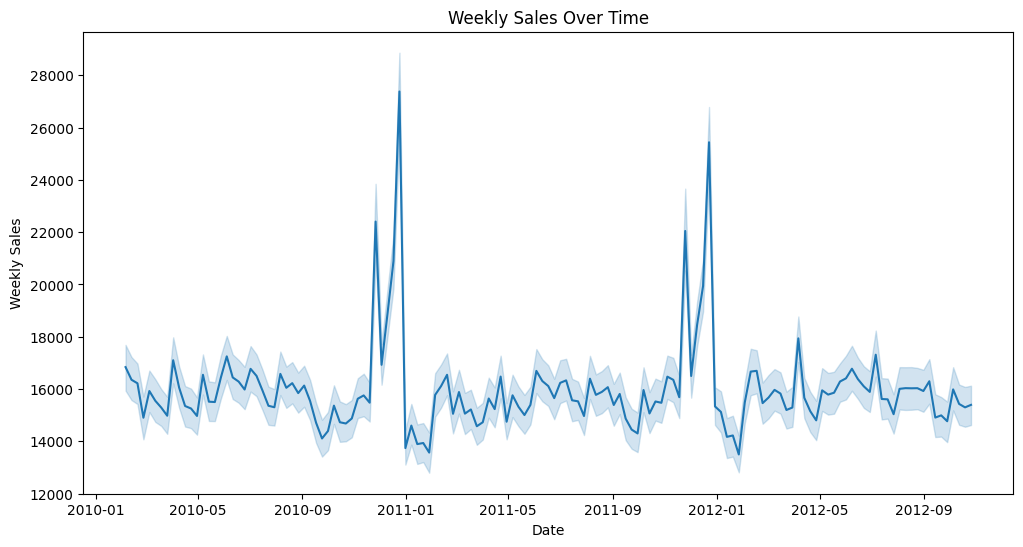

In [10]:
# Perform EDA
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_data, x=sales_data.index, y='Weekly_Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

<Figure size 1200x800 with 0 Axes>

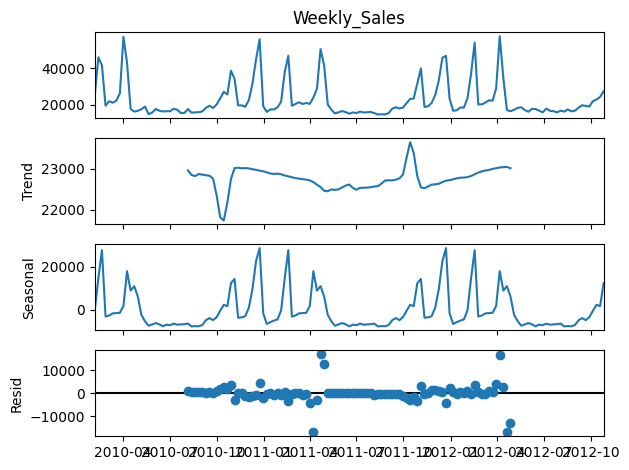

In [11]:
# Decompose the time series for a specific store and department
store_id = 1
dept_id = 1
store_dept_data = sales_data[(sales_data['Store'] == store_id) & (sales_data['Dept'] == dept_id)]

# Decompose the time series
decomposition = seasonal_decompose(store_dept_data['Weekly_Sales'], model='additive')
fig = plt.figure(figsize=(12, 8))
fig = decomposition.plot()
plt.show()

In [12]:
# Feature Engineering for Time Series Model
store_dept_data['sales_lag_1'] = store_dept_data['Weekly_Sales'].shift(1)
store_dept_data['sales_lag_7'] = store_dept_data['Weekly_Sales'].shift(7)
store_dept_data['sales_lag_30'] = store_dept_data['Weekly_Sales'].shift(30)

# Drop NA values generated by shifting
store_dept_data.dropna(inplace=True)

C:\Users\rohan\AppData\Local\Temp\ipykernel_3980\3485723013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_dept_data['sales_lag_1'] = store_dept_data['Weekly_Sales'].shift(1)
C:\Users\rohan\AppData\Local\Temp\ipykernel_3980\3485723013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_dept_data['sales_lag_7'] = store_dept_data['Weekly_Sales'].shift(7)
C:\Users\rohan\AppData\Local\Temp\ipykernel_3980\3485723013.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [13]:
# Train-test split
train_data, test_data = train_test_split(store_dept_data, test_size=0.2, shuffle=False)

# Define features and target
X_train = train_data[['sales_lag_1', 'sales_lag_7', 'sales_lag_30']]
y_train = train_data['Weekly_Sales']
X_test = test_data[['sales_lag_1', 'sales_lag_7', 'sales_lag_30']]
y_test = test_data['Weekly_Sales']

In [14]:
# Define error metrics functions
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # Handle division by zero
    return np.mean(diff) * 100

In [15]:
# Train models

# 1. Exponential Smoothing
model_hw = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=7).fit()
pred_hw = model_hw.forecast(len(y_test))

# 2. XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)

# 3. ARIMA
# Note: ARIMA requires the time series to be stationary. We will use the sales data directly for simplicity.
model_arima = ARIMA(y_train, order=(5,1,0))  # Adjust order as needed
model_arima_fit = model_arima.fit()
pred_arima = model_arima_fit.forecast(steps=len(y_test))

# 4. Random Forest
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsm

In [16]:
# Evaluate models
print("\nExponential Smoothing Results:")
print("Mean Absolute Error:", mean_absolute_error(y_test, pred_hw))
print("Mean Squared Error:", mean_squared_error(y_test, pred_hw))
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_test, pred_hw))
print("Symmetric Mean Absolute Percentage Error (SMAPE):", symmetric_mean_absolute_percentage_error(y_test, pred_hw))

print("\nXGBoost Results:")
print("Mean Absolute Error:", mean_absolute_error(y_test, pred_xgb))
print("Mean Squared Error:", mean_squared_error(y_test, pred_xgb))
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_test, pred_xgb))
print("Symmetric Mean Absolute Percentage Error (SMAPE):", symmetric_mean_absolute_percentage_error(y_test, pred_xgb))

print("\nARIMA Results:")
print("Mean Absolute Error:", mean_absolute_error(y_test, pred_arima))
print("Mean Squared Error:", mean_squared_error(y_test, pred_arima))
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_test, pred_arima))
print("Symmetric Mean Absolute Percentage Error (SMAPE):", symmetric_mean_absolute_percentage_error(y_test, pred_arima))

print("\nRandom Forest Results:")
print("Mean Absolute Error:", mean_absolute_error(y_test, pred_rf))
print("Mean Squared Error:", mean_squared_error(y_test, pred_rf))
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_test, pred_rf))
print("Symmetric Mean Absolute Percentage Error (SMAPE):", symmetric_mean_absolute_percentage_error(y_test, pred_rf))


Exponential Smoothing Results:
Mean Absolute Error: 7469.569572003685
Mean Squared Error: 100122088.23317958
Mean Absolute Percentage Error (MAPE): 42.18565352564905
Symmetric Mean Absolute Percentage Error (SMAPE): 15.5846106343786

XGBoost Results:
Mean Absolute Error: 1671.9695346467392
Mean Squared Error: 8681091.856353944
Mean Absolute Percentage Error (MAPE): 9.02367272669409
Symmetric Mean Absolute Percentage Error (SMAPE): 4.089805524436965

ARIMA Results:
Mean Absolute Error: 2963.5242610016885
Mean Squared Error: 11762601.511678603
Mean Absolute Percentage Error (MAPE): 16.32198371884502
Symmetric Mean Absolute Percentage Error (SMAPE): 7.702760044477912

Random Forest Results:
Mean Absolute Error: 1439.2500391304334
Mean Squared Error: 3913382.287217939
Mean Absolute Percentage Error (MAPE): 7.846938930062796
Symmetric Mean Absolute Percentage Error (SMAPE): 3.7437604717903747


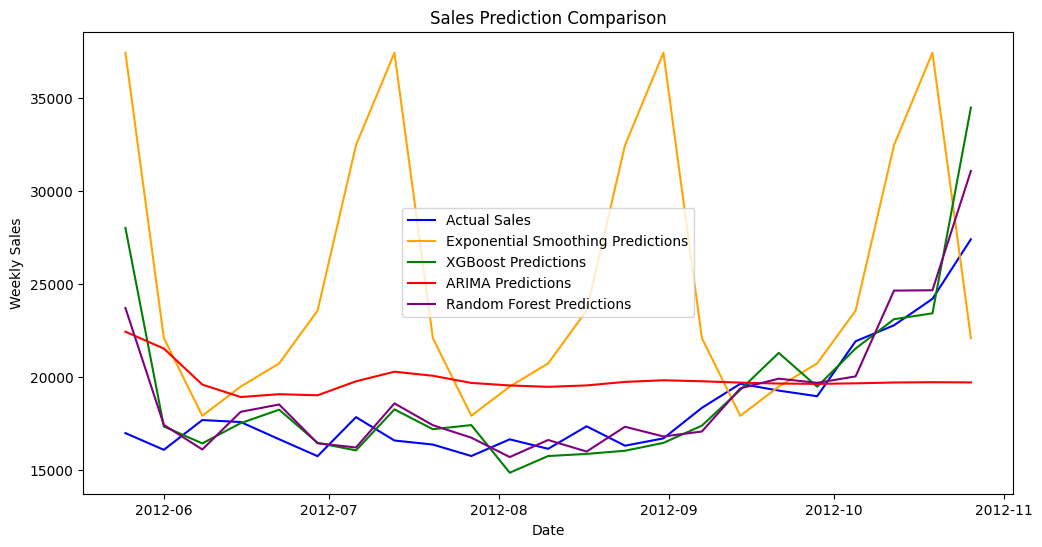

In [17]:
# Visualization of predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Sales', color='blue')
plt.plot(test_data.index, pred_hw, label='Exponential Smoothing Predictions', color='orange')
plt.plot(test_data.index, pred_xgb, label='XGBoost Predictions', color='green')
plt.plot(test_data.index, pred_arima, label='ARIMA Predictions', color='red')
plt.plot(test_data.index, pred_rf, label='Random Forest Predictions', color='purple')
plt.title('Sales Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

# Methods to improve results
Methods to Improve Results:
1. Incorporate additional features (e.g., promotional events, store type).
2. Experiment with more advanced models (e.g., Prophet, LSTM).
3. Optimize hyperparameters using grid search or random search.
4. Consider feature scaling for machine learning models.
5. Perform cross-validation to ensure model robustness.